This is the first exercise of Ch. 3 in the book "Hands-On Machine Learning with SciKit-Learn and Tensorflow" by Aurelion Geron.  The task is to build a classifier for the MNIST dataset that achieves 97% accuracy on the test set.  The suggestion is to use a KNeighborsClassifier and vary the hyperparameters.  It is also suggested to use Gridsearch on the 'weights' and 'n_neighbors' hyperparameters.

In [3]:
#First fetch the MNIST data set and take a look
#Note: The following is a work-around provided by Aurelion Geron that retrieves the MNIST data set from AMPlab
#at UC Berkeley.  The data set is no longer available from the PASCAL2 project.
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative....")
    
    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")


In [4]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [13]:
print(type(mnist))

<class 'sklearn.utils.Bunch'>


In [14]:
#Split MNIST data into a data array and a target (label) array:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

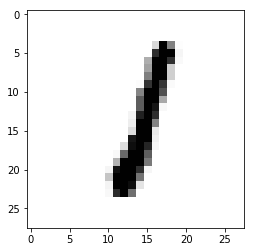

In [16]:
#So the data array (X) has 70,000 images (rows) with 784 features (columns).  Each image has 28x28 pixels, and each
#feature represents a pixel's intensity from 0 (white) to 255 (black).  An example of one digit can be previewed by
#using matplotlib:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit = X[12500]                              #pick a random image from the array of 70,000
digit_reshape = digit.reshape(28, 28)         #rework the pixels into a 28x28 array

plt.imshow(digit_reshape, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

In [17]:
#Well, this looks like a number 1 and we can see the pixelated structure.  Let's check what it really is according
#to the target set:
y[12500]

1.0

In [18]:
#Yay!  We were correct!

In [19]:
#Alright, so the task is to create a kick-butt classifier that uses the k-nearest-neighbours (kNN) algorithm.
#We need a training and testing data set: use the first 60000 images for training and the last 10000 for testing.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [20]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
type(X_train)

numpy.ndarray

In [22]:
y_test

array([0., 0., 0., ..., 9., 9., 9.])

In [23]:
type(y_test)

numpy.ndarray

In [25]:
#Let's look for NaN values in the array
import numpy as np
np.isnan(X_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
np.isnan(y_train)

array([False, False, False, ..., False, False, False])

In [28]:
#The textbook suggests shuffling the training set so the learning algorithms won't get used to the data.
#The .permutation method randomly shuffles the 60000 images.

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [29]:
#Ok.  So there isn't a lot of preprocessing to do on this data set, so let's go ahead and train the 
#KNeighborsClassifier on the data.

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()                #create an instance of the classifier
knn_clf.fit(X_train, y_train)                   #fit the hyperparameters to the data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [30]:
#Now let's predict images using the fitted data.
knn_predict = knn_clf.predict(X_test)

In [31]:
#How did we do?
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_predict)

0.9688

In [32]:
#Not quite 97%, but close!  The textbook suggests using GridSearchCV to find the best hyperparameters for the knn
#classifier.  The parameters that make sense to vary are: n_neighbors (number of neighbors to use for kneighbors
#queries) and weights (weight function used in prediction).  We will try three different n_neighbors parameters
#and two different weights for a total of 3 x 2 = 6 combinations of hyperparameters.  We are also training each
#model 5 times (since cv=5), so there will be 6 x 5 = 30 rounds of training.

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors':[1, 3, 5], 'weights':['uniform', 'distance']}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=distance, score=0.9721666666666666, total=34.3min
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=uniform, score=0.9721666666666666, total=34.3min
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=uniform, score=0.9712547908681887, total=34.

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 559.9min remaining: 86.1min


[CV]  n_neighbors=5, weights=distance, score=0.9698257897807785, total=29.3min
[CV]  n_neighbors=5, weights=distance, score=0.9729909969989997, total=29.2min
[CV] ..... n_neighbors=5, weights=distance, score=0.974, total=28.9min
[CV]  n_neighbors=5, weights=distance, score=0.9705049158473588, total=29.5min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 589.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [33]:
#Alright, note to self: Be careful with the choices for param_grid!  This model took almost 10 hours to run!
#Let's look at the best estimator:

grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [34]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [43]:
grid_search.best_score_

0.97255

In [36]:
gs_results = grid_search.cv_results_
gs_results

/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/

{'mean_fit_time': array([102.39720564,  99.53854089,  98.12642813, 107.25129995,
        105.76309147,  87.63297768]),
 'mean_score_time': array([1960.94030132, 1970.97920628, 1992.4066679 , 2032.99388652,
        2026.77737966, 1738.99051218]),
 'mean_test_score': array([0.97145   , 0.97145   , 0.9713    , 0.97255   , 0.96991667,
        0.97171667]),
 'mean_train_score': array([1.        , 1.        , 0.985675  , 1.        , 0.98054998,
        1.        ]),
 'param_n_neighbors': masked_array(data=[1, 1, 3, 3, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1, 'weights': 'uniform'},
  {'n_neighbors': 1, 'weights': 'distance'},
  {'n_neighbors': 3

In [41]:
#Let's try seeing this in a Pandas dataframe

import pandas as pd
results = pd.DataFrame(gs_results)
results_transposed = results.T             #transpose dataframe so info is easier to see
results_transposed

/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/erena/anaconda3/lib/python3.6/

,0,1,2,3,4,5
mean_fit_time,102.397,99.5385,98.1264,107.251,105.763,87.633
mean_score_time,1960.94,1970.98,1992.41,2032.99,2026.78,1738.99
mean_test_score,0.97145,0.97145,0.9713,0.97255,0.969917,0.971717
mean_train_score,1,1,0.985675,1,0.98055,1
param_n_neighbors,1,1,3,3,5,5
param_weights,uniform,distance,uniform,distance,uniform,distance
params,"{'n_neighbors': 1, 'weights': 'uniform'}","{'n_neighbors': 1, 'weights': 'distance'}","{'n_neighbors': 3, 'weights': 'uniform'}","{'n_neighbors': 3, 'weights': 'distance'}","{'n_neighbors': 5, 'weights': 'uniform'}","{'n_neighbors': 5, 'weights': 'distance'}"
rank_test_score,3,3,5,1,6,2
split0_test_score,0.971512,0.971512,0.970012,0.971845,0.96918,0.971262
split0_train_score,1,1,0.985644,1,0.980165,1


In [44]:
#Yay!  It looks like we managed our goal of getting >97% accuracy with this model.  The best parameters are 
#n_neighbors = 3 and weight = 'distance'.  The score was 97.255% .

In [45]:
#Now let's predict with the testing data set and take another look at the accuracy score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9717

In [46]:
#Not as good as the training accuracy, but still better than 97%!  This is the end of exercise 1.